#SEC Financial Data

The SEC maintains a database (EDGAR) of financial data reported from all walks of industry that describes a complete account of the company's performance. In this project, I demonstrate how to navigate the SEC database to find 10-k filings, which are the recepticle for the specific reports themselves. I write functions that make use of SEC nomenclature to automatically the navigate various database hierarchies and finally arrive at desired 10-k's. Then, I make use of scraping to pull financial data from the documents held within the 10k, store it in a dataframe, and plot my findings. 

The process requires supervision, as the sec hierarchy is not completely ubiquitous. This process could be even more automated with a some alterations, and be used to pull and scrape data from financial documents of many companies 

#libraries

In [ ]:
# import requisite libraries
import requests
import urllib
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

#url builder

In [ ]:
# used to assemble urls
def url_build(url_base, component):
    
    url = url_base
    
    # add each component to the base url
    for y in component:
        url = '{}/{}'.format(url, y)
        
    return url

#pull SEC listings. listings by time -> listings by company

In [ ]:
# define the base url for daily SEC filings
url_base = "https://www.sec.gov/Archives/edgar/daily-index"

# The daily filings require a year and content type
url_year = url_build(url_base, ['2019', 'index.json'])

# display daily listings by year URL
print('-'*100)
print('Daily listings for: {}'.format('2019'))
print("link: " + url_year)

# request content for that year's listings, convert to json 
content = requests.get(url_year)
content_decoded = content.json()

# navigate the index hierearchy
for item in content_decoded['directory']['item'][0:1]:
    
    # get the quarter
    print('-'*100)
    print('Quarter: {}'.format(item['name']))
    
    # assemble the url for the filings for that quarter
    url_qtr = url_build(url_base, ['2019', item['name'], 'index.json'])
    
    # print out the url.
    print("Link: " + url_qtr)
    
    # request the quarterly filings url as a .json
    content_file = requests.get(url_qtr)
    content_decoded = content_file.json()
    
    print('-'*100)
    print('Grab Files')

    # access the quarterly filings list and pull filings using the url conventions
    for filing in content_decoded['directory']['item'][0:200]:
        
        # grab master file type for parseability and details
        if 'master' in filing['name']:
          url_file = url_build(url_base, ['2019', item['name'], filing['name']])
          print("Index Link: " + url_file)

----------------------------------------------------------------------------------------------------
Daily listings for: 2019
link: https://www.sec.gov/Archives/edgar/daily-index/2019/index.json
----------------------------------------------------------------------------------------------------
Quarter: QTR1
Link: https://www.sec.gov/Archives/edgar/daily-index/2019/QTR1/index.json
----------------------------------------------------------------------------------------------------
Grab Files
Index Link: https://www.sec.gov/Archives/edgar/daily-index/2019/QTR1/master.20190102.idx
Index Link: https://www.sec.gov/Archives/edgar/daily-index/2019/QTR1/master.20190103.idx
Index Link: https://www.sec.gov/Archives/edgar/daily-index/2019/QTR1/master.20190104.idx
Index Link: https://www.sec.gov/Archives/edgar/daily-index/2019/QTR1/master.20190107.idx
Index Link: https://www.sec.gov/Archives/edgar/daily-index/2019/QTR1/master.20190108.idx
Index Link: https://www.sec.gov/Archives/edgar/daily-index/

#migrate list of company listings to txt

In [ ]:
# the master listings all contain the directory locations of filings for many companies
# assume a single master index url
master_url = "https://www.sec.gov/Archives/edgar/daily-index/2019/QTR2/master.20190401.idx"

# request the master list content
content = requests.get(master_url).content

# write the content to a file
with open('master_20190102.txt', 'wb') as q:
     q.write(content)

#parse the list of company listings

In [ ]:
# load the byte data for the master index
with open('master_20190102.txt','rb') as q:
     data_byte = q.read()

# decode and split the byte data
master_data = data_byte.decode("utf-8").split('  ')

# remove the header
for num, info in enumerate(master_data):
    if "ftp://ftp.sec.gov/edgar/" in info:
        ind_start = num

# redefine dataset without the header
format_data = master_data[ind_start + 1:]

master_list = []

# break the index into sections
for num, info in enumerate(format_data):
    
    # initialize the list
    if num == 0:
        item_data_clean = info.replace('\n','|').split('|')
        item_data_clean = item_data_clean[8:]
    else:
        item_data_clean = info.replace('\n','|').split('|')
    
    # group the appropriate objects together    
    for num, table_row in enumerate(item_data_clean):
        
        # find the text file
        if '.txt' in table_row:

            # scrape the associated values
            list_mini = item_data_clean[(num - 4): num + 1]
            
            # build the url
            if len(list_mini) != 0:
                list_mini[4] = "https://www.sec.gov/Archives/" + list_mini[4]
                master_list.append(list_mini)
                
master_list[:]

#store the company listing data in dictionaries

In [ ]:
# loop through each company in the master list
for num, info in enumerate(master_list):
  
  # create a dictionary for each company in the master list
  company_dict = {}
  company_dict['number_cik'] = info[0]
  company_dict['name_company'] = info[1]
  company_dict['id_form'] = info[2]
  company_dict['date'] = info[3]
  company_dict['url'] = info[4]
  
  master_list[num] = company_dict

#pull the companies with 10-k listings

In [ ]:
# use the dictionary to access data
for company_dict in master_list[0:100]:

    # get the 10-k documents
    if company_dict['id_form'] == '10-K':
        
        # get the components
        name_comp = company_dict['name_company']
        url_company = company_dict['url']
        
        print('-'*100)
        print(name_comp)
        print(url_company)

----------------------------------------------------------------------------------------------------
GENERAL STEEL HOLDINGS INC
https://www.sec.gov/Archives/edgar/data/1239188/0001144204-19-017485.txt
----------------------------------------------------------------------------------------------------
COMMONWEALTH INCOME & GROWTH FUND V
https://www.sec.gov/Archives/edgar/data/1253347/0001654954-19-003881.txt
----------------------------------------------------------------------------------------------------
Joway Health Industries Group Inc
https://www.sec.gov/Archives/edgar/data/1263364/0001213900-19-005388.txt


#pull a 10-k summary from a company

In [ ]:

# assign the base url
url_base = "https://www.sec.gov"

# after finding a suitable example, 
#convert the 10-k to json, in this example used 10-k for Monitronics International
url_doc = "https://www.sec.gov/Archives/edgar/data/1265107/0001265107-19-000004.txt"
url_doc = url_doc.replace('-','').replace('.txt','/index.json')

# request the doc an decode it
content = requests.get(url_doc).json()

# take files from the 10-k
for doc in content['directory']['item']:
    
    # Grab the filing summary
    if doc['name'] == 'FilingSummary.xml':

        filing_summary = url_base + content['directory']['name'] + "/" + doc['name']
        
        print('-' * 100)
        print('File Name: ' + doc['name'])
        print('File Path: ' + filing_summary)

----------------------------------------------------------------------------------------------------
File Name: FilingSummary.xml
File Path: https://www.sec.gov/Archives/edgar/data/1265107/000126510719000004/FilingSummary.xml


#parse the various reports from inside the 10-k summary

In [ ]:
# make a base url for the filing summary
url_base = filing_summary.replace('FilingSummary.xml', '')

# request the content and parse it
content = requests.get(filing_summary).content
soup = BeautifulSoup(content, 'lxml')

# navigate to the myreports tab
report_list = soup.find('myreports')

# create a list to store the dictionaries that hold data for each report
reports_master = []

# loop through each report
for info in report_list.find_all('report')[:-1]:

    # store the data in a dictionary
    dict_report = {}
    dict_report['name_short'] = info.shortname.text
    dict_report['name_long'] = info.longname.text
    dict_report['position'] = info.position.text
    dict_report['category'] = info.menucategory.text
    dict_report['url'] = url_base + info.htmlfilename.text

    # store the dictionary in a list
    reports_master.append(dict_report)

    # print the info
    print('-'*100)
    print(url_base + info.htmlfilename.text)
    print(info.longname.text)
    print(info.shortname.text)
    print(info.menucategory.text)
    print(info.position.text)

#pull specifically the financial statements

In [ ]:
# create a list to store the financial statement urls
url_statements = []

for dict_report in reports_master:
    
    # assign the names of the financial statements
    it1 = "Consolidated Balance Sheets"
    it2 = "Consolidated Statements of Operations and Comprehensive Income (Loss)"
    it3 = "Consolidated Statements of Cash Flows"
    it4 = "Consolidated Statements of Stockholder's (Deficit) Equity"
    
    # store them in a list.
    list_reports = [it1, it2, it3, it4]
    
    # search for the statement names in the 10-k
    if dict_report['name_short'] in list_reports:
        
        # print some info and store it in the statements url.
        print('-'*100)
        print(dict_report['name_short'])
        print(dict_report['url'])
        
        url_statements.append(dict_report['url'])

----------------------------------------------------------------------------------------------------
Consolidated Balance Sheets
https://www.sec.gov/Archives/edgar/data/1265107/000126510719000004/R2.htm
----------------------------------------------------------------------------------------------------
Consolidated Statements of Operations and Comprehensive Income (Loss)
https://www.sec.gov/Archives/edgar/data/1265107/000126510719000004/R4.htm
----------------------------------------------------------------------------------------------------
Consolidated Statements of Cash Flows
https://www.sec.gov/Archives/edgar/data/1265107/000126510719000004/R5.htm
----------------------------------------------------------------------------------------------------
Consolidated Statements of Stockholder's (Deficit) Equity
https://www.sec.gov/Archives/edgar/data/1265107/000126510719000004/R6.htm


#scrape the financial statements

In [ ]:

# create a list to hold the statements data
data_statements = []

# loop through the statement urls
for statement_url in url_statements:
    
    # setup dictionary to hold each statement's pieces
    data_statement = {}
    data_statement['headers'] = []
    data_statement['sections'] = []
    data_statement['data'] = []
    
    # request the statement file content
    Content = requests.get(statement_url).content
    soup_report = BeautifulSoup(Content, 'html')

    # find row, row type, parse element, store in list
    for num, info in enumerate(soup_report.table.find_all('tr')):
        
        # get the elements
        columns = info.find_all('td')
        
        # identify regular rows as opposed to section/table headers
        if (len(info.find_all('th')) == 0 and len(info.find_all('strong')) == 0): 
            row_reg = [el.text.strip() for el in columns]
            data_statement['data'].append(row_reg)
            
        # identify a section header
        elif (len(info.find_all('th')) == 0 and len(info.find_all('strong')) != 0):
            row_sec = columns[0].text.strip()
            data_statement['sections'].append(row_sec)
            
        # identify a table header
        elif (len(info.find_all('th')) != 0):            
            row_hed = [el.text.strip() for el in info.find_all('th')]
            data_statement['headers'].append(row_hed)
            
        else:            
            print('We encountered an error.')

    # store the statement data in a list
    data_statements.append(data_statement)

#convert the data to a dataframe

In [ ]:
# pull the components of the financial statements
header_income =  data_statements[1]['headers'][1]
data_income = data_statements[1]['data']

# store the components in a dataframe
df_income = pd.DataFrame(data_income)

# Change the index
df_income.index = df_income[0]
df_income.index.name = 'Category'
df_income = df_income.drop(0, axis = 1)

# Clean the data for legibility and completeness
df_income = df_income.replace('[\$,)]','', regex=True )\
                     .replace( '[(]','-', regex=True)\
                     .replace( '', 'NaN', regex=True)

# convert strings to floats
df_income = df_income.astype(float)

# change the headers
df_income.columns = header_income

# convert to csv
df_income.to_csv('state_income.csv')

# show the final df
df_income

,"Dec. 31, 2018","Sep. 30, 2018","Jun. 30, 2018","Mar. 31, 2018","Dec. 31, 2017","Sep. 30, 2017","Jun. 30, 2017","Mar. 31, 2017","Dec. 31, 2018","Dec. 31, 2017","Dec. 31, 2016"
Category,,,,,,,,,,,
Net revenue,134436.0,137156.0,135013.0,133753.0,133546.0,138211.0,140498.0,141200.0,540358.0,553455.0,570372.0
Cost of services,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128939.0,119193.0,115236.0
"Selling, general and administrative, including stock-based and long-term incentive compensation",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118940.0,155902.0,114152.0
Radio conversion costs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,450.0,18422.0
"Amortization of subscriber accounts, deferred contract acquisition costs and other intangible assets",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211639.0,236788.0,246753.0
Depreciation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11434.0,8818.0,8160.0
Loss on goodwill impairment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,563549.0,0.0,0.0
Total operating expenses,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1034501.0,521151.0,502723.0
Operating income (loss),-316590.0,12280.0,-201845.0,12012.0,14647.0,12896.0,-11848.0,16609.0,-494143.0,32304.0,67649.0


In [ ]:
#Clean the table
df = df_income.T
df1 = df.iloc[::-1]
df1

Category,Net revenue,Cost of services,"Selling, general and administrative, including stock-based and long-term incentive compensation",Radio conversion costs,"Amortization of subscriber accounts, deferred contract acquisition costs and other intangible assets",Depreciation,Loss on goodwill impairment,Total operating expenses,Operating income (loss),Interest expense,Unrealized loss on derivative financial instruments,Refinancing expense,Total other expense,Loss before income taxes,Income tax expense (benefit),Net loss,"Unrealized gain on derivative contracts, net","Total other comprehensive income, net of tax",Comprehensive loss
"Dec. 31, 2016",570372.0,115236.0,114152.0,18422.0,246753.0,8160.0,0.0,502723.0,67649.0,127308.0,0.0,9500.0,136808.0,-69159.0,7148.0,-76307.0,4589.0,4589.0,-71718.0
"Dec. 31, 2017",553455.0,119193.0,155902.0,450.0,236788.0,8818.0,0.0,521151.0,32304.0,145492.0,0.0,0.0,145492.0,-113188.0,-1893.0,-111295.0,1582.0,1582.0,-109713.0
"Dec. 31, 2018",540358.0,128939.0,118940.0,0.0,211639.0,11434.0,563549.0,1034501.0,-494143.0,180770.0,3151.0,12238.0,196159.0,-690302.0,-11552.0,-678750.0,14378.0,14378.0,-664372.0
"Mar. 31, 2017",141200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16609.0,NaN,NaN,NaN,NaN,NaN,NaN,-21013.0,NaN,NaN,NaN
"Jun. 30, 2017",140498.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11848.0,NaN,NaN,NaN,NaN,NaN,NaN,-50104.0,NaN,NaN,NaN
"Sep. 30, 2017",138211.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12896.0,NaN,NaN,NaN,NaN,NaN,NaN,-25536.0,NaN,NaN,NaN
"Dec. 31, 2017",133546.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14647.0,NaN,NaN,NaN,NaN,NaN,NaN,-14642.0,NaN,NaN,NaN
"Mar. 31, 2018",133753.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12012.0,NaN,NaN,NaN,NaN,NaN,NaN,-26207.0,NaN,NaN,NaN
"Jun. 30, 2018",135013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-201845.0,NaN,NaN,NaN,NaN,NaN,NaN,-241792.0,NaN,NaN,NaN
"Sep. 30, 2018",137156.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12280.0,NaN,NaN,NaN,NaN,NaN,NaN,-33840.0,NaN,NaN,NaN


#Plot the Net Revenue over time for Monitronics International

Text(0, 0.5, 'Net Revenue')

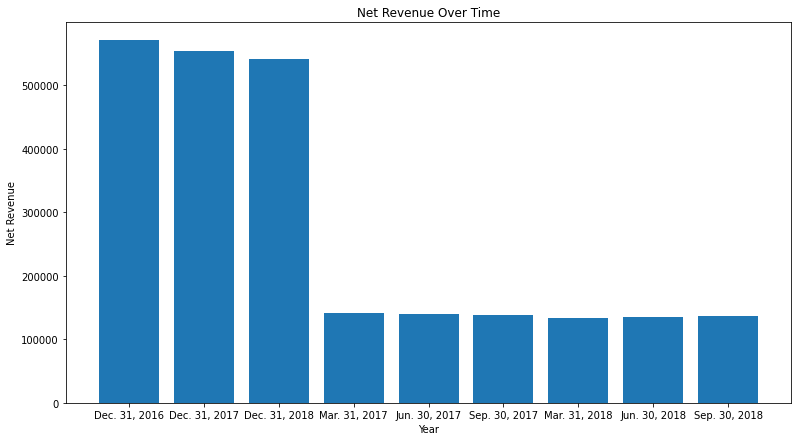

In [ ]:
# Plot the Net Revenue over Time
plt.figure(figsize=(13, 7))
x = df1.index
y = df1['Net revenue']
plt.bar(x, y)
plt.title('Net Revenue Over Time')
plt.xlabel('Year')
plt.ylabel('Net Revenue')


#NOTE

Well done! You did a good job pulling data from various webpages and cleaning/compiling it into something usable. For your next steps, you could try building a regression model to see how the other factors you scraped affected the Company's revenue. You could also create a time series model to predict how a company's revenue will be in the future.